# Linear Regression

In [1]:
import utils

# utils.fetch_housing_data()
housing = utils.load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The `info()` method is useful to get a quick description of the data, in particular the total number of rows, each attribute’s type, and the number of nonnull values.

In [2]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Notice that the total_bedrooms attribute has only 20,433 nonnull values, meaning that 207 districts are missing this feature.

You can find out what categories exist and how many districts belong to each category by using the `value_counts()` method.

In [3]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Let’s look at the other fields. The describe() method shows a summary of the numerical attributes.

In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


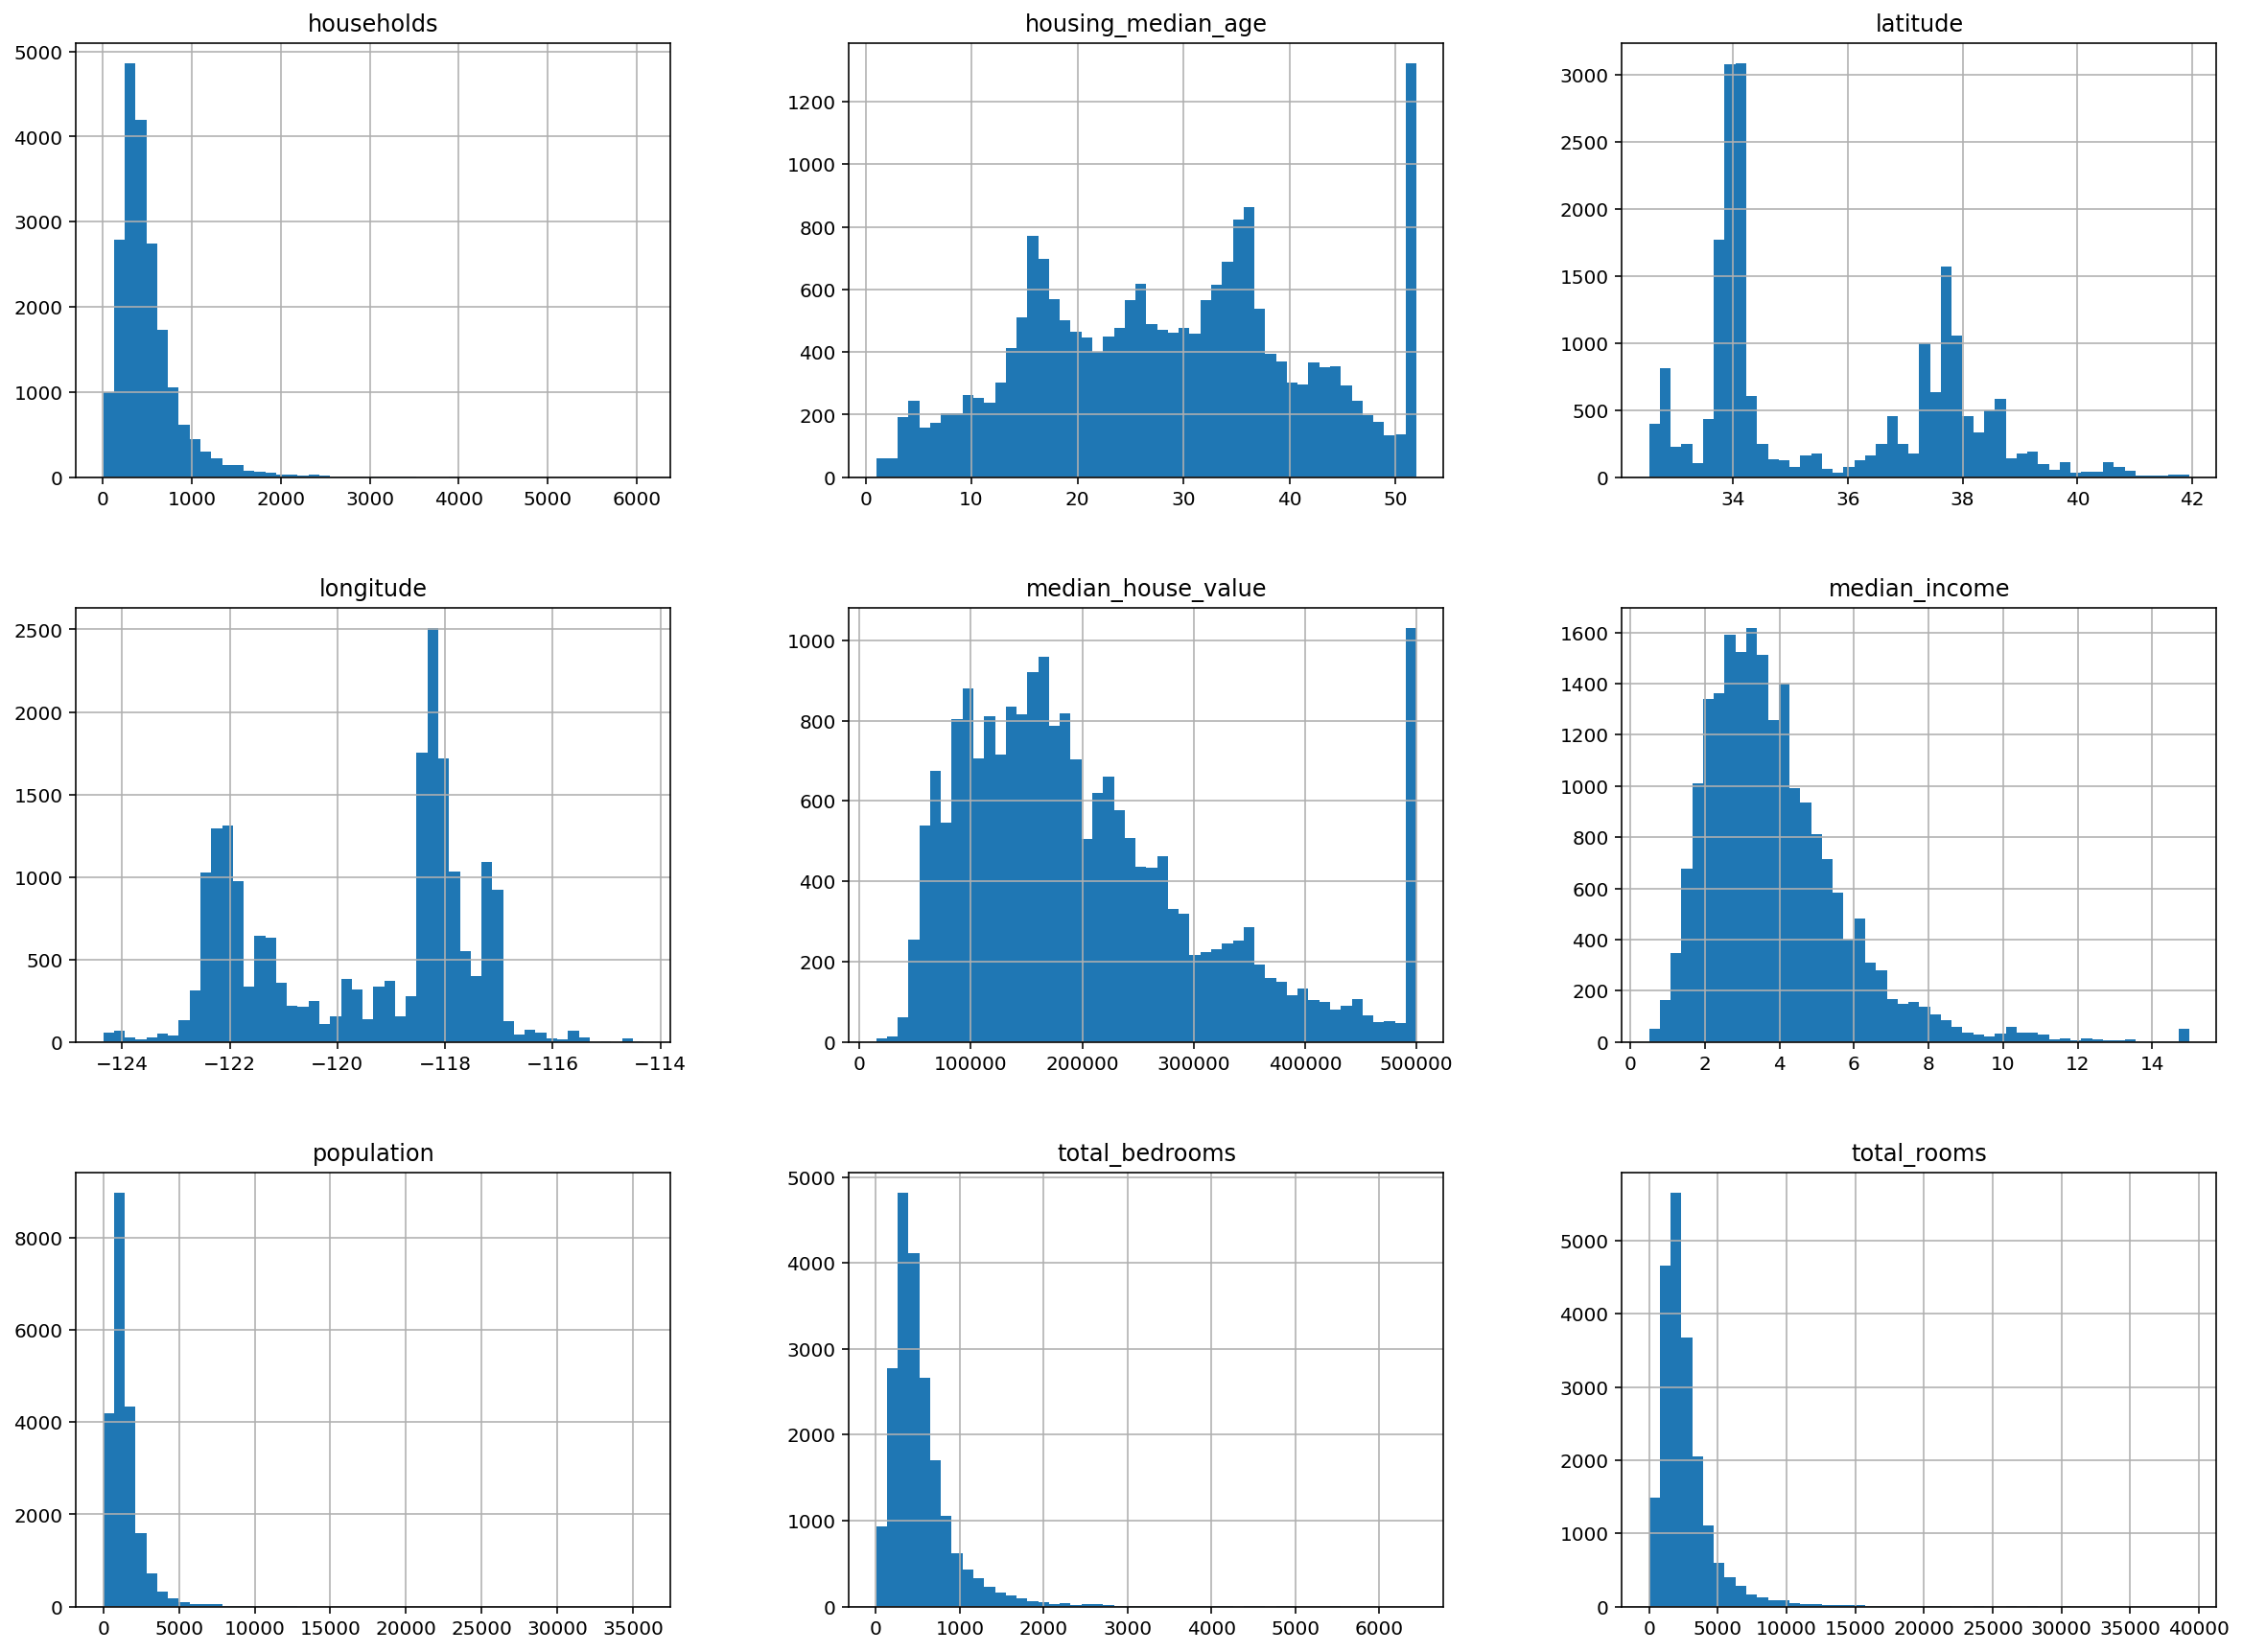

In [5]:
import matplotlib.pyplot as plt

# Show inline and in high resolution
%matplotlib inline
%config InlineBackend.figure_format='retina'

housing.hist(bins=50, figsize=(20, 15))
plt.show()

Many histograms are tail-heavy : they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

## Test Set

When you estimate the generalization error using the test set, your estimate will be too optimistic, and you will launch a system that will not perform as well as expected. This is called *data snooping* bias.

In [6]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute. Let’s look at the median income histogram more closely: most median income values are clustered around 1.5 to 6 (i.e., USD 15,000 – USD 60,000), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of a stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. The following code uses the `pd.cut()` function to create an income category attribute with five categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on.

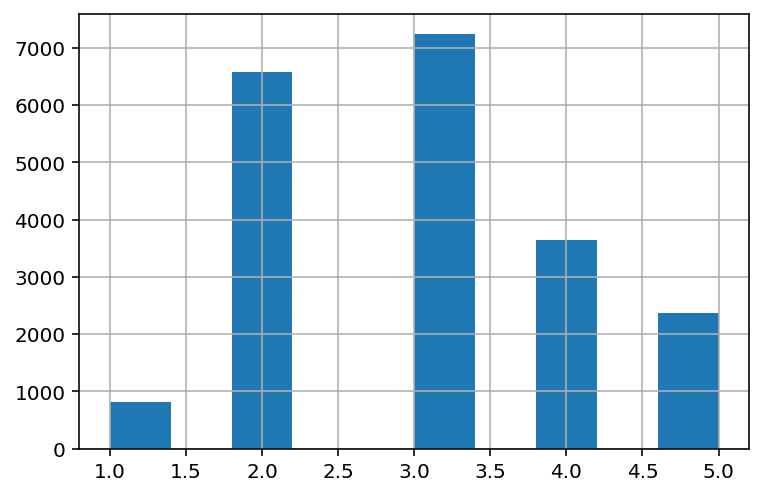

In [7]:
import pandas as pd
import numpy as np

housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [9]:
for strat_set in (strat_train_set, strat_test_set):
    strat_set.drop("income_cat", inplace=True, axis=1)

## Discover and Visualize the Data to Gain Insights 

If the set is very large you should to sample and exploration set, to make manipulations easy and fast. Otherwise just make a copy of your set to experiment without inadvertently changing it. 

In [10]:
housing = strat_train_set.copy()

### Visualizing Geographical Data

We can use the geographical information (latitude and logitude) to create a scatter plot of all districts.

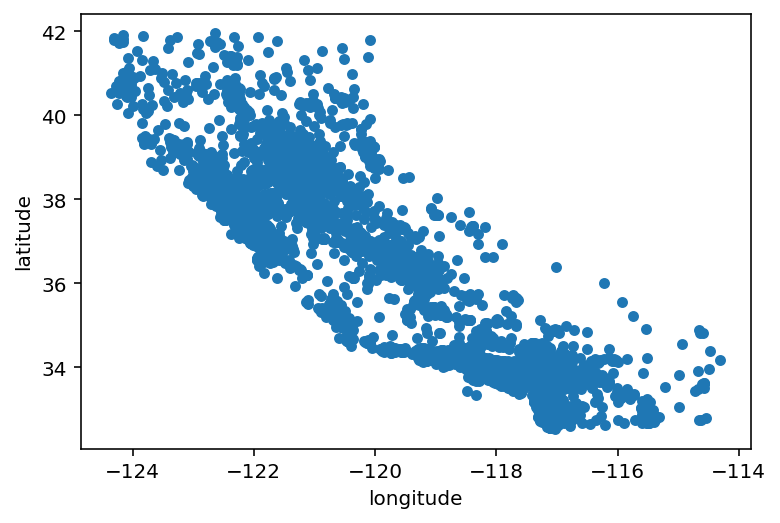

In [11]:
housing.plot(kind="scatter", x="longitude", y="latitude")

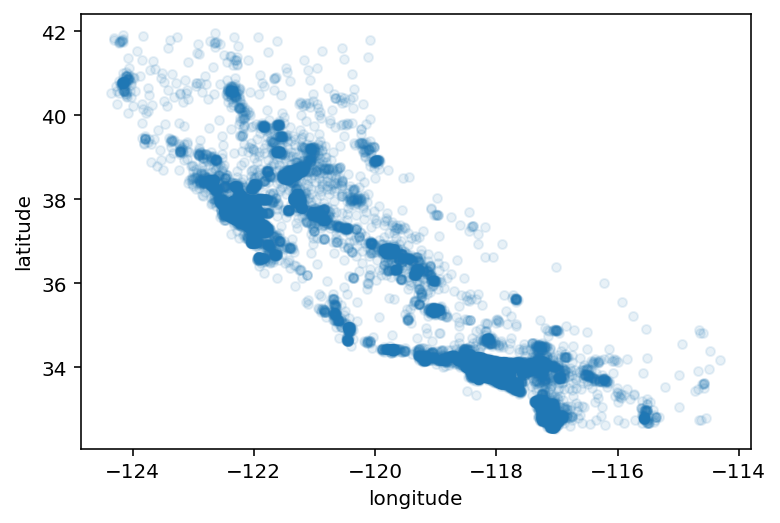

In [12]:
# By adjusting the alpha value we can better visualize the density
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

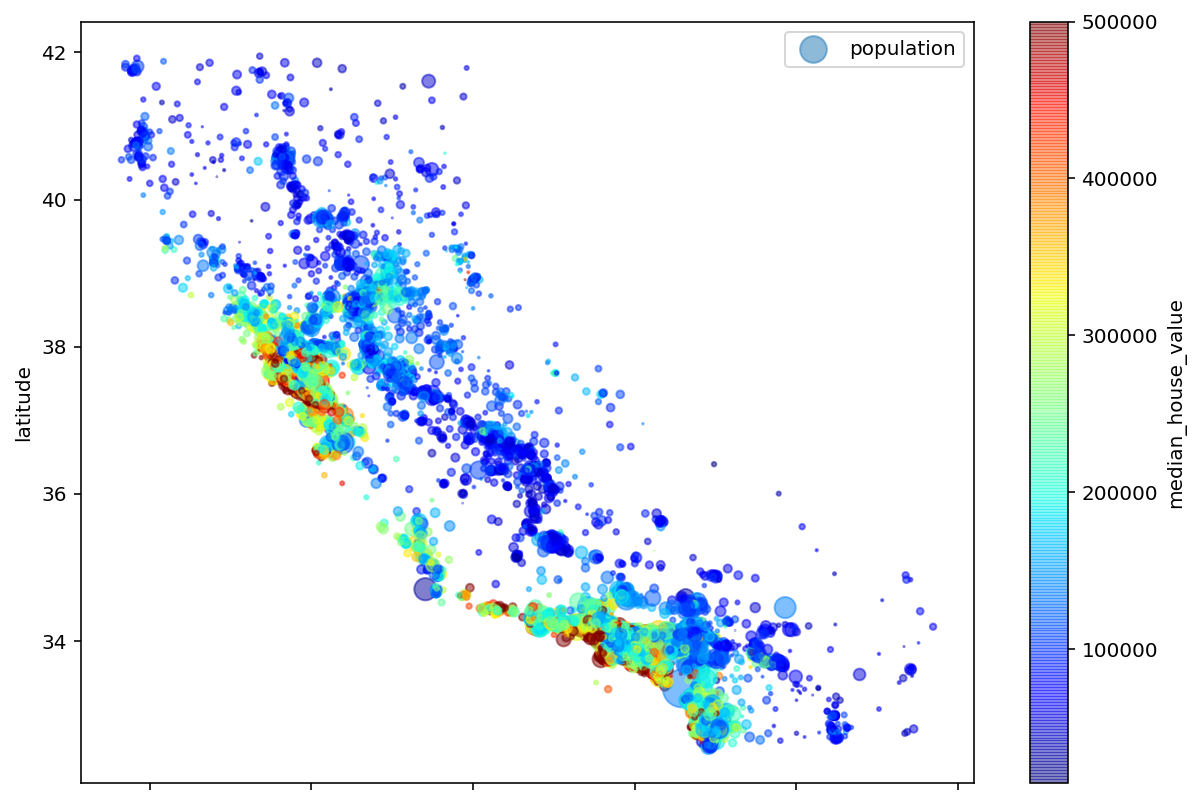

In [13]:
# But we can do even better by colorizing the map and setting the radius of each point to reference the population density
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5, s=housing["population"] / 100, label="population", figsize=(10, 7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

### Looking for Correlations

In [14]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

You can also use pandas to visualize correlations

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1d86f31c0>,
      dtype=object)

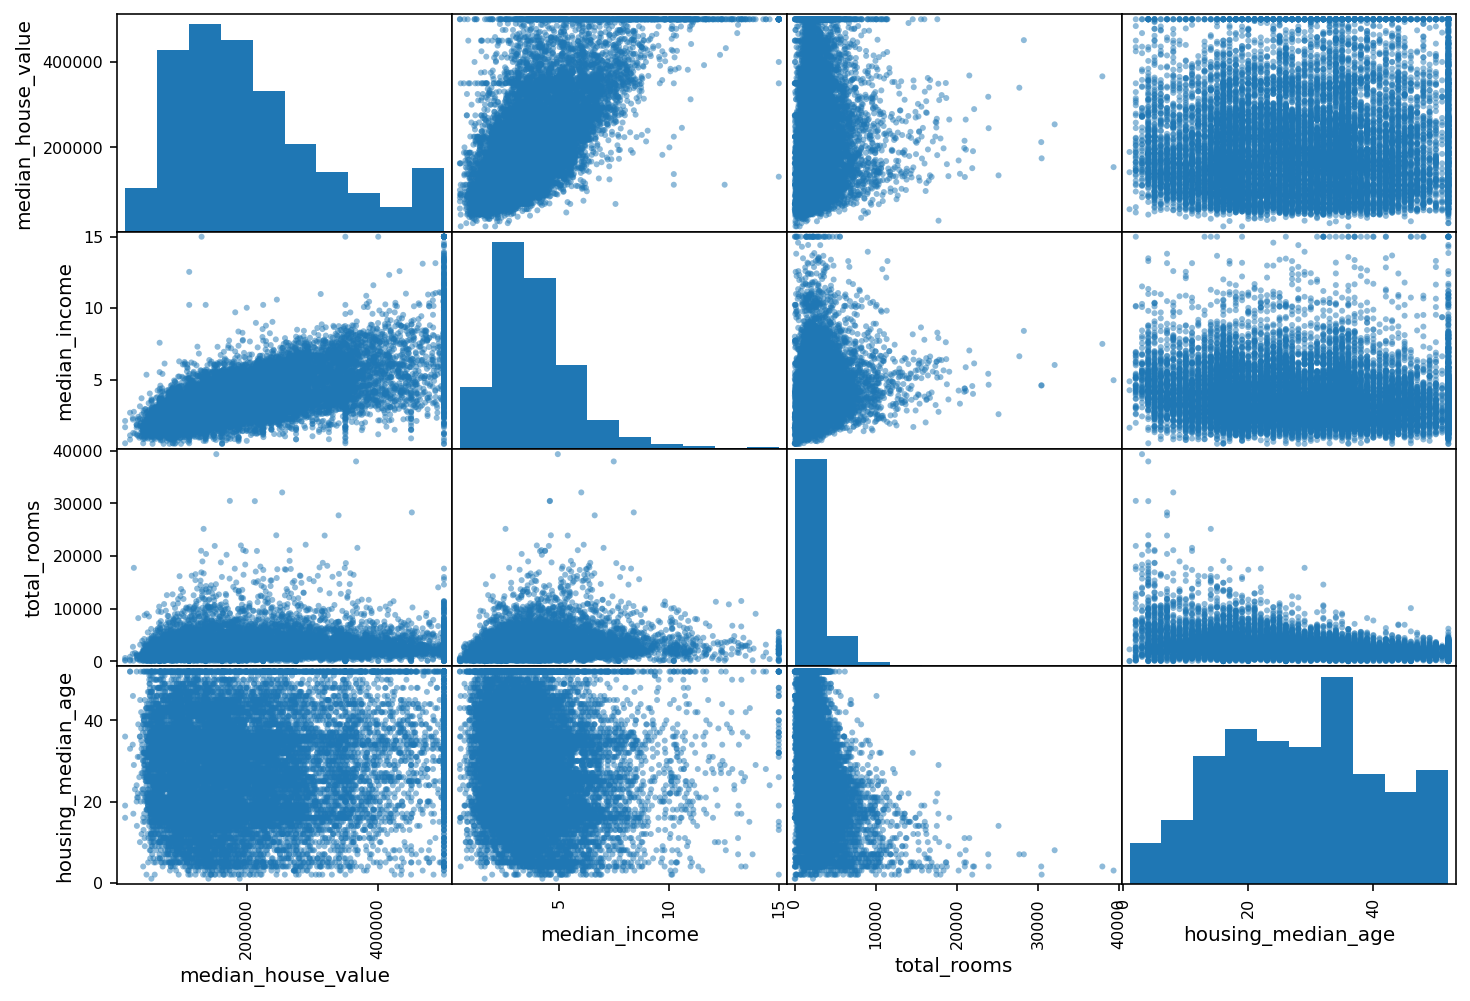

In [15]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

The median house value seems to have a strong correlation with median income

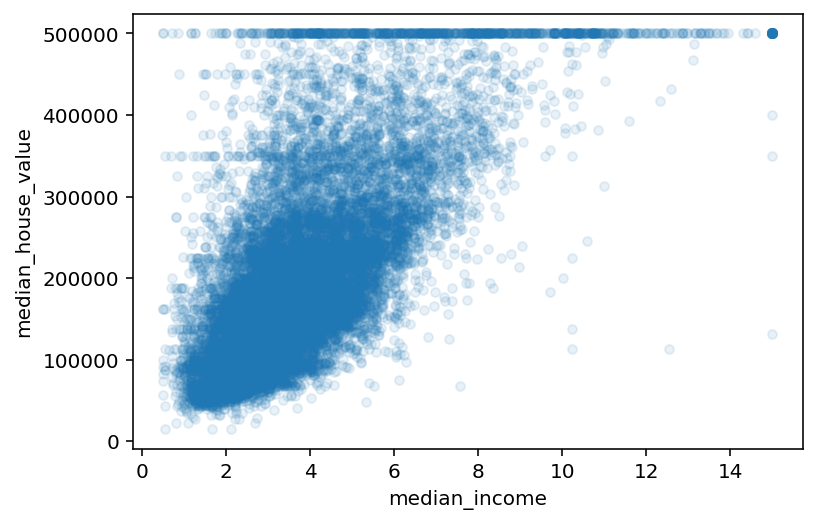

In [16]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

### Experimenting with Attribute Combinations

One last thing you may want to do before preparing the data for Machine Learning algorithms is to try out various attribute combinations. For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. Let’s create these new attributes.

In [17]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Prepare the Data for Machine Learning Algorithms

First let’s revert to a clean training set (by copying `strat_train_set` once again). Let’s also separate the predictors and the labels, since we don’t necessarily want to apply the same transformations to the predictors and the target values (note that `drop()` creates a copy of the data and does not affect `strat_train_set`).

In [18]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [19]:
housing.dropna(subset = ["total_bedrooms"]) # option 1 
housing.drop("total_bedrooms", axis=1) # option 2
median = housing["total_bedrooms"].median() # option 3 
housing["total_bedrooms"].fillna(median, inplace=True ) 

Scikit-Learn provides a handy class to take care of missing values: `SimpleImputer`. Here is how to use it. First, you need to create a SimpleImputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute.

In [20]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_numerical_only = housing.drop("ocean_proximity", axis=1)
X = imputer.fit_transform(housing_numerical_only)
housing_tr = pd.DataFrame(X, columns=housing_numerical_only.columns, index=housing_numerical_only.index)

### Handling Text and Categorical Attributes

So far we have only dealt with numerical attributes, but now let’s look at text attributes. In this dataset, there is just one: the `ocean_proximity` attribute. Let’s look at its value for the first 10 instances.

In [21]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [22]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
print(housing_cat_encoded[:10])

[[0.]
 [0.]
 [4.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [23]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [24]:
"""One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad,” “average,” “good,” and “excellent”), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1)."""
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very useful when you have categorical attributes with thousands of categories. After one-hot encoding, we get a matrix with thousands of columns, and the matrix is full of 0s except for a single 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the nonzero elements. You can use it mostly like a normal 2D array, 21 but if you really want to convert it to a (dense) NumPy array, just call the `toarray()` method.

In [25]:
housing_cat_1hot.toarray() 

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])